In [2]:
# Packages
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap, ListedColormap, Normalize, TwoSlopeNorm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Modules
from modules.connector import MyBigQuery

In [3]:
# Instantiate BigQuery instance.
bq = MyBigQuery(credentials_file='./credentials/New AutoMotive Index-487e031dc242.json')

In [4]:
# Set table and query.
# table = "`rugged-baton-283921.mot_anonymised.mainNew`"
query = """
WITH VehicleData AS (
  SELECT
    vehicleId,
    test_mileage,
    testDate,
    firstUsedDate,
    DATE_DIFF(CURRENT_DATE(), firstUsedDate, YEAR) AS yearsOfService,
    CASE
      WHEN fuelType IN ('ED', 'OT', 'CN', 'GA', 'GB', 'GD', 'LNG', 'LNP', 'ST', 'FC', 'LP', 'LN') THEN 'other'
      WHEN fuelType = 'DI' THEN 'diesel'
      WHEN fuelType = 'EL' THEN 'electric'
      WHEN fuelType = 'HY' THEN 'hybrid'
      WHEN fuelType = 'PE' THEN 'petrol'
      ELSE fuelType
    END AS convertedFuelType
  FROM
    `rugged-baton-283921.mot_anonymised.mainNew`
  WHERE
    testDate >= DATE_SUB(CURRENT_DATE(), INTERVAL 2 YEAR)
        AND testTesult IN ('P', 'PRS')
        AND testClassId = 4
        AND `test_mileage` IS NOT NULL
),

RecentVehicleData AS (
  SELECT
    vehicleId,
    MAX(testDate) AS mostRecentTestDate
  FROM
    VehicleData
  GROUP BY
    vehicleId
)

SELECT
  vd.vehicleId,
  vd.firstUsedDate,
  vd.testDate,
  rvd.mostRecentTestDate,
  vd.yearsOfService,
  vd.test_mileage,
  vd.convertedFuelType AS fuelType,
  CASE
    WHEN vd.yearsOfService > 0 THEN vd.test_mileage / vd.yearsOfService
    ELSE 0
  END AS avgYearlyMileage
FROM
  VehicleData AS vd
JOIN
  RecentVehicleData AS rvd
ON
  vd.vehicleId = rvd.vehicleId
  AND vd.testDate = rvd.mostRecentTestDate
"""

In [5]:
# Get data.
df = bq.from_bq_to_dataframe(
    query=query
)
df

,vehicleId,firstUsedDate,testDate,mostRecentTestDate,yearsOfService,test_mileage,fuelType,avgYearlyMileage
0,119987615,2020-02-14,2022-10-05,2022-10-05,3,16196.0,petrol,5398.666667
1,1053819192,1991-09-19,2022-07-18,2022-07-18,32,51631.0,petrol,1613.468750
2,616615852,1993-05-25,2022-07-15,2022-07-15,30,70681.0,petrol,2356.033333
3,801866822,2000-09-01,2022-06-16,2022-06-16,23,75713.0,petrol,3291.869565
4,176918168,1993-04-26,2022-11-07,2022-11-07,30,165814.0,petrol,5527.133333
...,...,...,...,...,...,...,...,...
32104547,1150642760,2001-06-07,2022-08-25,2022-08-25,22,88884.0,petrol,4040.181818
32104548,360612888,2001-09-28,2022-10-19,2022-10-19,22,127438.0,diesel,5792.636364
32104549,1240320606,2001-10-24,2022-01-26,2022-01-26,22,138633.0,diesel,6301.500000
32104550,665622472,2001-10-18,2022-05-31,2022-05-31,22,56605.0,petrol,2572.954545


In [6]:
# Set an array of fuelTypes.
fuelTypes = ['other', 'diesel', 'electric', 'hybrid', 'petrol']

In [7]:
# Get total vehicles in parc, sum of their average mileages, and the average of the total.
df_result = df.groupby('fuelType').agg({
    'vehicleId': 'count',
    'avgYearlyMileage': ['sum', 'mean']
})
df_result.columns = ['count', 'sumOfAvgs', 'totalAvgMileage']
df_result

,count,sumOfAvgs,totalAvgMileage
fuelType,,,
diesel,14158068,1.216654e+11,8593.358639
electric,114803,7.877461e+08,6861.720591
hybrid,656418,5.591875e+09,8518.771689
other,31352,2.823633e+08,9006.229959
petrol,17143911,9.279776e+10,5412.869840


In [23]:
litres_per_gallon = 4.54609

# https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1040512/env0103.ods
diesel_mpg = 56.1
petrol_mpg = 52.6

# Calculate miles per litre.
petrol_mpl = petrol_mpg / litres_per_gallon
diesel_mpl = diesel_mpg / litres_per_gallon

# year to date average (2022-09-20 -> 2023-09-20)
avg_litre_cost_petrol = 1.505557692307692
avg_litre_cost_diesel = 1.6493961538461535

# Avg. over year 2022
# avg_litre_cost_petrol = 1.646586538461539
# avg_litre_cost_diesel = 1.7778961538461533

# Cost in pounds per mile.
diesel_pounds_per_mile = avg_litre_cost_diesel / diesel_mpl
petrol_pounds_per_mile = avg_litre_cost_petrol / petrol_mpl

# EV Efficiency
ev_efficiency = 1 / 3.5 # 3.5 is avg miles per kWh - kWh/miles: https://www.fleetalliance.co.uk/driver-ev/mpg-to-kwh-electric-car-efficiency-explained/#:~:text=Most%20EVs%20will%20cover%20between,it%20will%20cost%20to%20run
ev_avg_kWh_cost = 0.3 # £/kWh: https://energysavingtrust.org.uk/about-us/our-data#jumpto-6
ev_cost_per_mile = ev_efficiency * ev_avg_kWh_cost

perMileCost = {'diesel': diesel_pounds_per_mile, 'petrol': petrol_pounds_per_mile, 'electric': ev_cost_per_mile}

for index, row in df_result.iterrows():
    if index in ['petrol', 'diesel', 'electric']:
        print(index)
        annual_cost = row['totalAvgMileage'] * perMileCost[index]
        print(index, annual_cost)
        print("\n")

diesel
diesel 1148.5848478522778


electric
electric 588.1474792706413


petrol
petrol 704.3317585647654




In [24]:
# Year to date 2023-09-20
# Electric = 588.1139016026
# Petrol = 704.3256636091023
# Diesel = 1148.6156799547155

EV_vs_Diesel_saving = 1148.6156799547155 - 588.1139016026
EV_vs_Petrol_saving = 704.3256636091023 - 588.1139016026

# Total year avg. 2022
# Electric = 588.1139016026
# Petrol = 770.3027573886641
# Diesel = 1238.0887124892133

# EV_vs_Diesel_saving = 1238.0887124892133 - 588.1139016026
# EV_vs_Petrol_saving = 770.3027573886641 - 588.1139016026

print(
    "How much less the average EV driver spends on fuel per year:\n",
    "Petrol: " + str(EV_vs_Petrol_saving),
    "\n",
    "Diesel: " + str(EV_vs_Diesel_saving)
)

How much less the average EV driver spends on fuel per year:
 Petrol: 116.21176200650234 
 Diesel: 560.5017783521155


In [25]:
# Per Mile Costs:
print(
    diesel_pounds_per_mile, "\n",
    petrol_pounds_per_mile, "\n",
    ev_cost_per_mile
)

0.1336595964534485 
 0.13012168763161744 
 0.0857142857142857


<hr  />

Heatmap

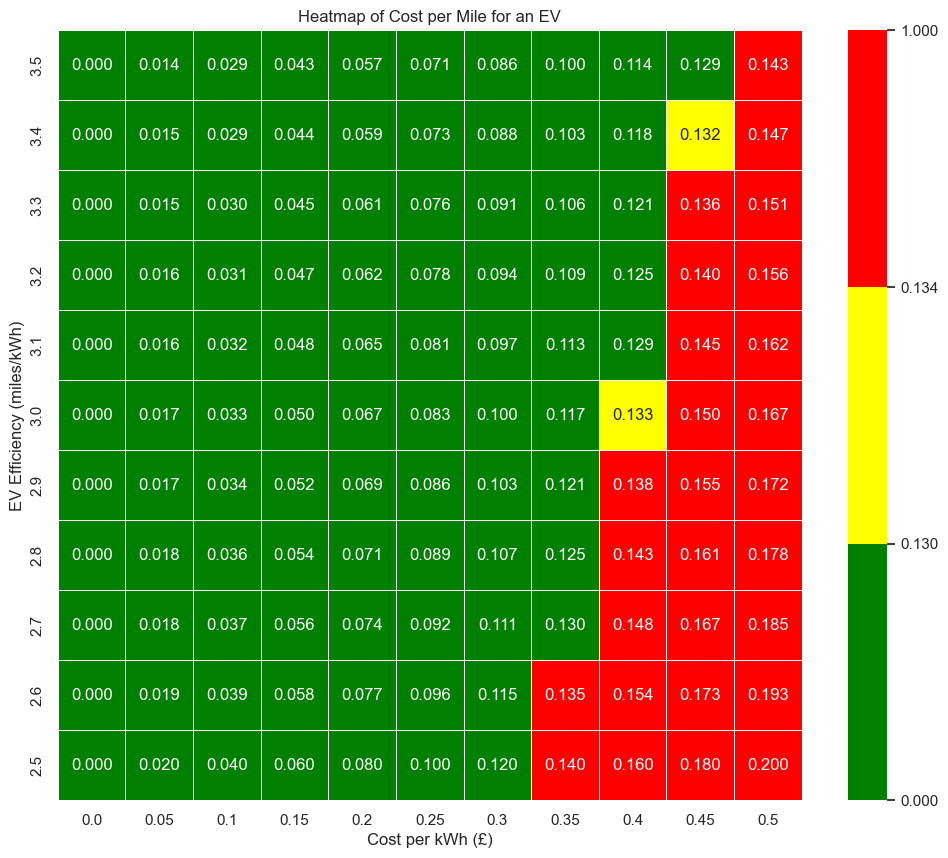

In [26]:
# Define the arrays
kWh_costs = [round(i * 0.05, 2) for i in range(11)]
ev_miles_per_kWh = [round((3.5 - i * 0.1), 2) for i in range(11)]
ev_efficiencies = [round(1 / i, 3) for i in ev_miles_per_kWh]

# Create an empty matrix to store the results
result_matrix = np.outer(ev_efficiencies, kWh_costs)

# Create a DataFrame from the result matrix
df_heat = pd.DataFrame(result_matrix, columns=kWh_costs, index=ev_miles_per_kWh)

# Define map colours
colours = ['green', 'yellow', 'red']
# Borders for colours
boundaries = [0, min(petrol_pounds_per_mile, diesel_pounds_per_mile), max(petrol_pounds_per_mile, diesel_pounds_per_mile), 1]

cmap = ListedColormap(colours)
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

plt.figure(figsize=(12, 10))
sns.set()
ax = sns.heatmap(df_heat, annot=True, cmap=cmap, norm=norm, fmt=".3f", linewidths=.5)
plt.ylabel('EV Efficiency (miles/kWh)')
plt.xlabel('Cost per kWh (£)')
plt.title('Heatmap of Cost per Mile for an EV')
plt.show()

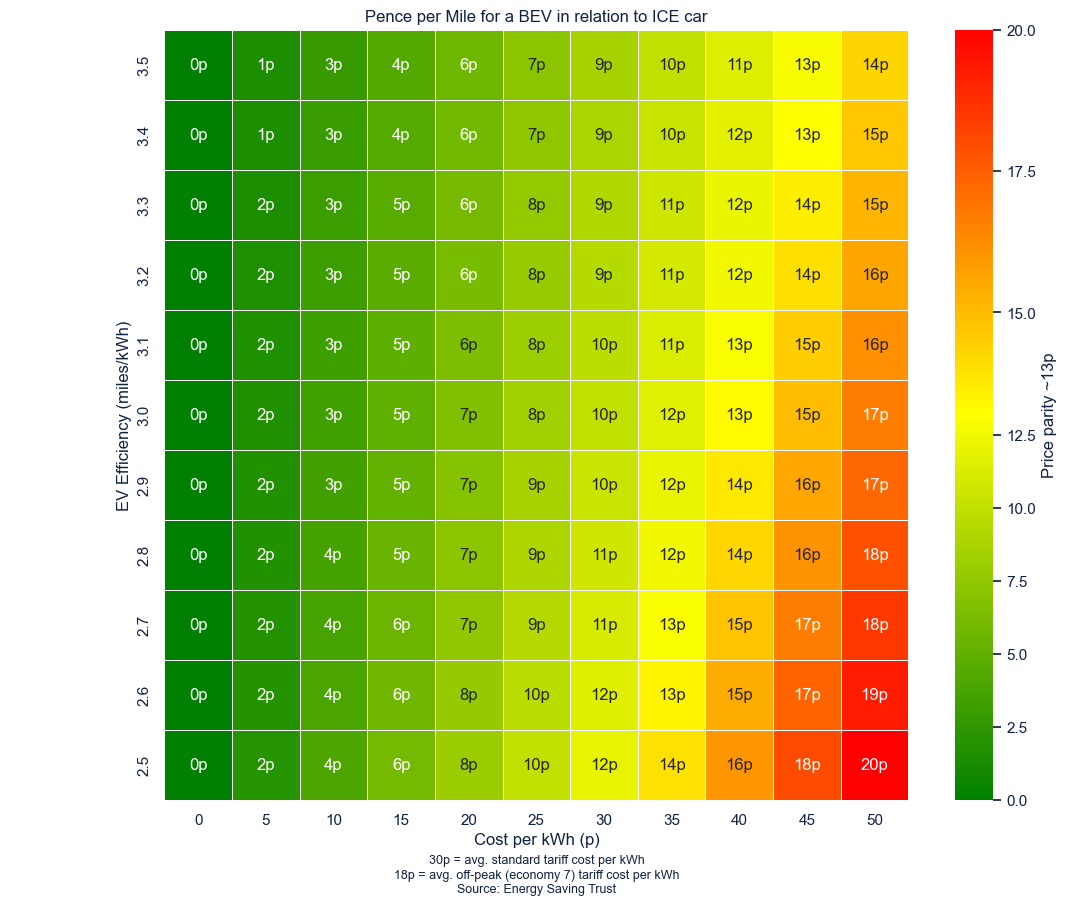

In [42]:
# Define the arrays.
kWh_costs = [round(i * 5, 2) for i in range(11)] # Pence per kWh
ev_miles_per_kWh = [round((3.5 - i * 0.1), 2) for i in range(11)]
ev_efficiencies = [round(1 / i, 3) for i in ev_miles_per_kWh]

# Create an empty matrix to store the results.
result_matrix = np.outer(ev_efficiencies, kWh_costs)

# Create a DataFrame from the result matrix.
df_heat = pd.DataFrame(result_matrix, columns=kWh_costs, index=ev_miles_per_kWh)

# Define map colours.
colours = ['green', 'yellow', 'red']
# Number of colour bins.
n_bins = 1000
# Name of new cmap.
cmap_name = "CheaperToDearer"

custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colours, N=n_bins)

# midpoint = 0.13
# midpoint = 13
midpoint = (100 * (petrol_pounds_per_mile + diesel_pounds_per_mile)) / 2

# Normalize around the 13p mark for price parity.
norm = TwoSlopeNorm(vmin=df_heat.values.min(), vcenter=midpoint, vmax=df_heat.values.max())

# Define plot
plt.figure(figsize=(12, 10))
sns.set()
ax = sns.heatmap(df_heat, annot=True, cmap=custom_cmap, norm=norm, fmt=".0f", linewidths=.5)
for t in ax.texts:
    t.set_text(t.get_text() + "p")
plt.ylabel('EV Efficiency (miles/kWh)', color="#0f2242")
plt.xlabel('Cost per kWh (p)', color="#0f2242")
plt.title('Pence per Mile for a BEV in relation to ICE car', color="#0f2242")

ax.tick_params(axis='x', colors="#0f2242")
ax.tick_params(axis='y', colors="#0f2242")

# Image doesn't seem to render, but this helps leave space to edit one in.
image = plt.imread("./assets/new-automotive-logo-dark.png")
fig = plt.gcf()
ax_image = OffsetImage(image, zoom=0.05)
ab = AnnotationBbox(ax_image, (1.05, -0.2), frameon=False)
fig.gca().add_artist(ab)

footnote_text = "30p = avg. standard tariff cost per kWh\n18p = avg. off-peak (economy 7) tariff cost per kWh\nSource: Energy Saving Trust"
plt.annotate(footnote_text, (0.5, -0.12), xycoords="axes fraction", fontsize=9, ha="center", color='#0f2242')

cbar = ax.collections[0].colorbar
cbar.set_label("Price parity ~13p", color='#0f2242')
cbar.ax.yaxis.set_tick_params(colors="#0F2242")

plt.show()